In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
pd.set_option('precision', 3)

# Data Visualisation Libraries
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

!pip install seaborn --upgrade
import seaborn as sns
sns.set_style('darkgrid')

# Statistics
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 7.5 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


# Model building

In [2]:
train_df = pd.read_csv('/content/drive/MyDrive/MIT/Hackathon/MergedTrainData_NaNMean.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70252 entries, 0 to 70251
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      70252 non-null  int64  
 1   Gender                  70252 non-null  int64  
 2   Customer_Type           70252 non-null  float64
 3   Age                     70252 non-null  float64
 4   Travel_Class            70252 non-null  int64  
 5   Travel_Distance         70252 non-null  int64  
 6   Arrival_Delay_in_Mins   70252 non-null  float64
 7   Overall_Experience      70252 non-null  int64  
 8   Seat_Comfort            70252 non-null  float64
 9   Catering                70252 non-null  float64
 10  Platform_Location       70252 non-null  float64
 11  Onboard_Wifi_Service    70252 non-null  float64
 12  Onboard_Entertainment   70252 non-null  float64
 13  Online_Support          70252 non-null  float64
 14  Ease_of_Online_Booking  70252 non-null

In [3]:
scaler = StandardScaler()

scl_columns = ['Arrival_Delay_in_Mins', 'Age', 'Travel_Distance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

print('✔️ Features Scaled!')

✔️ Features Scaled!


In [4]:
#feature_cols = ['Gender', 'Travel_Class', 'Travel_Distance', 'Arrival_Delay_in_Mins', "Seat_Comfort", "Platform_Location"]
cols_drop = ["Overall_Experience", "Travel_Class", "Onboard_Wifi_Service", "Platform_Location", "Baggage_Handling", "Legroom"]

y_train = train_df['Overall_Experience']
X_train = train_df.drop(cols_drop, axis=1)

In [5]:
random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}


In [6]:
def plot_conf_mx(cm, ax):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned']);

In [7]:
def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    '''Plot the learning curves for an estimator in the specified axes object.'''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14);

In [8]:
def clf_performance(classifier, classifier_name, classifier_name_abv):
    '''Display the overall performance of a classifier with this template.'''
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  cv=5,
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(y_train, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(y_train, y_pred),
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp), fpr, tpr
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)

    plt.tight_layout();


 Random Forest
-------------------------------
   Best Score (recall): 0.913
   Best Parameters: 
      bootstrap: False
      criterion: gini
      max_depth: 6
      max_features: auto
      min_samples_leaf: 5
      min_samples_split: 2
      n_estimators: 100


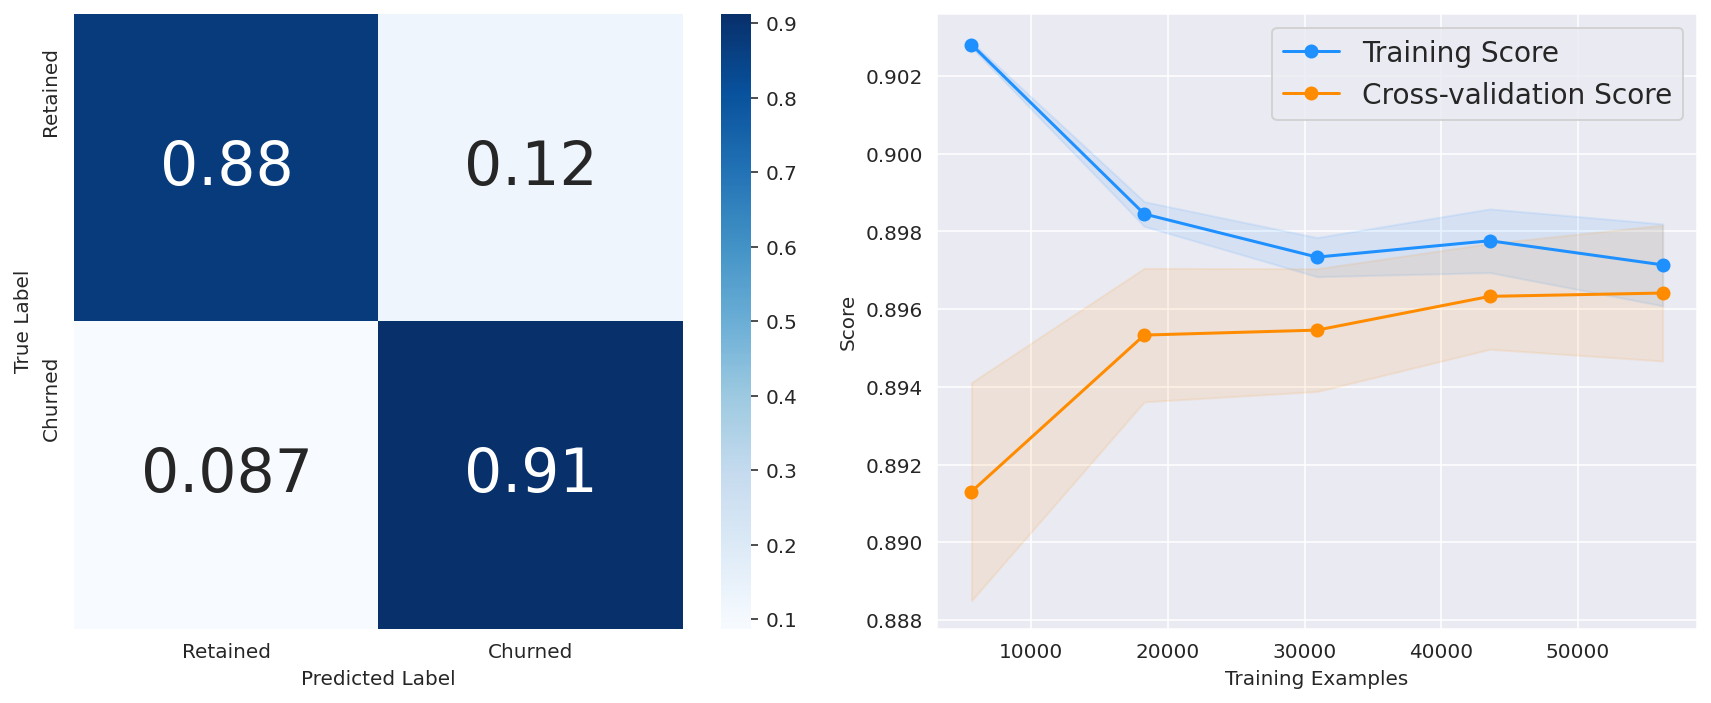

In [9]:
rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

Test using test data

In [10]:
test_df = pd.read_csv('/content/drive/MyDrive/MIT/Hackathon/MergedTestData_NanMean.csv')

In [11]:
scaler = StandardScaler()

scl_columns = ['Arrival_Delay_in_Mins', 'Age', 'Travel_Distance']
test_df[scl_columns] = scaler.fit_transform(test_df[scl_columns])

print('✔️ Features Scaled!')

✔️ Features Scaled!


In [12]:
feature_cols = ['Gender', 'Travel_Class', 'Travel_Distance', 'Arrival_Delay_in_Mins', "Seat_Comfort", "Platform_Location"]
cols_drop = ["Travel_Class", "Onboard_Wifi_Service", "Platform_Location", "Baggage_Handling", "Legroom"]

# # y is a vector, hence we use dot to access 'label'
# y = test_df.Overall_Experience

#y_test = test_df['Overall_Experience']
X_test = test_df.drop(cols_drop, axis=1)

In [13]:
y_pred_class = best_rf_clf.predict(X_test)

In [14]:
# calculate accuracy
from sklearn import metrics
# print(metrics.accuracy_score(y_test, y_pred_class))

In [15]:
# examine the class distribution of the testing set (using a Pandas Series method)
# y_test.value_counts()

In [16]:
# calculate the percentage of ones
# because y_test only contains ones and zeros, we can simply calculate the mean = percentage of ones
# y_test.mean()

In [17]:
# calculate the percentage of zeros
# 1 - y_test.mean()

In [18]:
# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
# max(y_test.mean(), 1 - y_test.mean())

In [19]:
# calculate null accuracy (for multi-class classification problems)
# y_test.value_counts().head(1) / len(y_test)

In [14]:
# print the first 25 true and predicted responses
#print('True:', y_test.values[0:25])
print('False:', y_pred_class[0:100])

False: [1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1
 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0]


In [15]:
sample_submission_df = pd.read_csv('/content/drive/MyDrive/MIT/Hackathon/Sample_Submission_(1).csv')

In [16]:
sample_submission_df.info()
sample_submission_df = sample_submission_df.drop(["Overall_Experience"], axis=1)
sample_submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   ID                  35602 non-null  int64
 1   Overall_Experience  35602 non-null  int64
dtypes: int64(2)
memory usage: 556.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      35602 non-null  int64
dtypes: int64(1)
memory usage: 278.3 KB


In [17]:
len(y_pred_class)

35602

In [18]:
se = pd.Series(y_pred_class)
sample_submission_df['Overall_Experience'] = se.values

In [19]:
sample_submission_df.head(25)

,ID,Overall_Experience
0,99900001,1
1,99900002,0
2,99900003,1
3,99900004,0
4,99900005,1
5,99900006,1
6,99900007,0
7,99900008,0
8,99900009,1
9,99900010,0


In [20]:
sample_submission_df.to_csv("/content/drive/MyDrive/MIT/Hackathon/PredictionData_v8_NaNMean.csv", index=False)